In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchinfo import summary

import requests
import gradio as gr
from PIL import Image
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from os import listdir
from glob import glob 
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Hyperparameters
IN_CHANNEL = 3
NUM_CLASSES = 5
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

# 1.Dataset

 kaggle : https://www.kaggle.com/datasets/antobenedetti/animals

In [146]:
# get number of images for each class
class_names = ['cat', 'dog', 'elephant', 'horse', 'lion']
cls_name = glob('../../Kaggle_Dataset/MultiClass_Classification/Animals/train/*')
cls_split = [cls.split('\\')[-1] for cls in cls_name]
cls_df = pd.DataFrame({}, columns=['Animal','Count'])

for i, cls in enumerate(cls_name):
    cls_df = cls_df._append({'Animal': cls_split[i],
                             'Count':len(glob(cls + '/*'))}, ignore_index=True)
cls_df.head()

,Animal,Count
0,cat,2737
1,dog,2627
2,elephant,2730
3,horse,2705
4,lion,2675


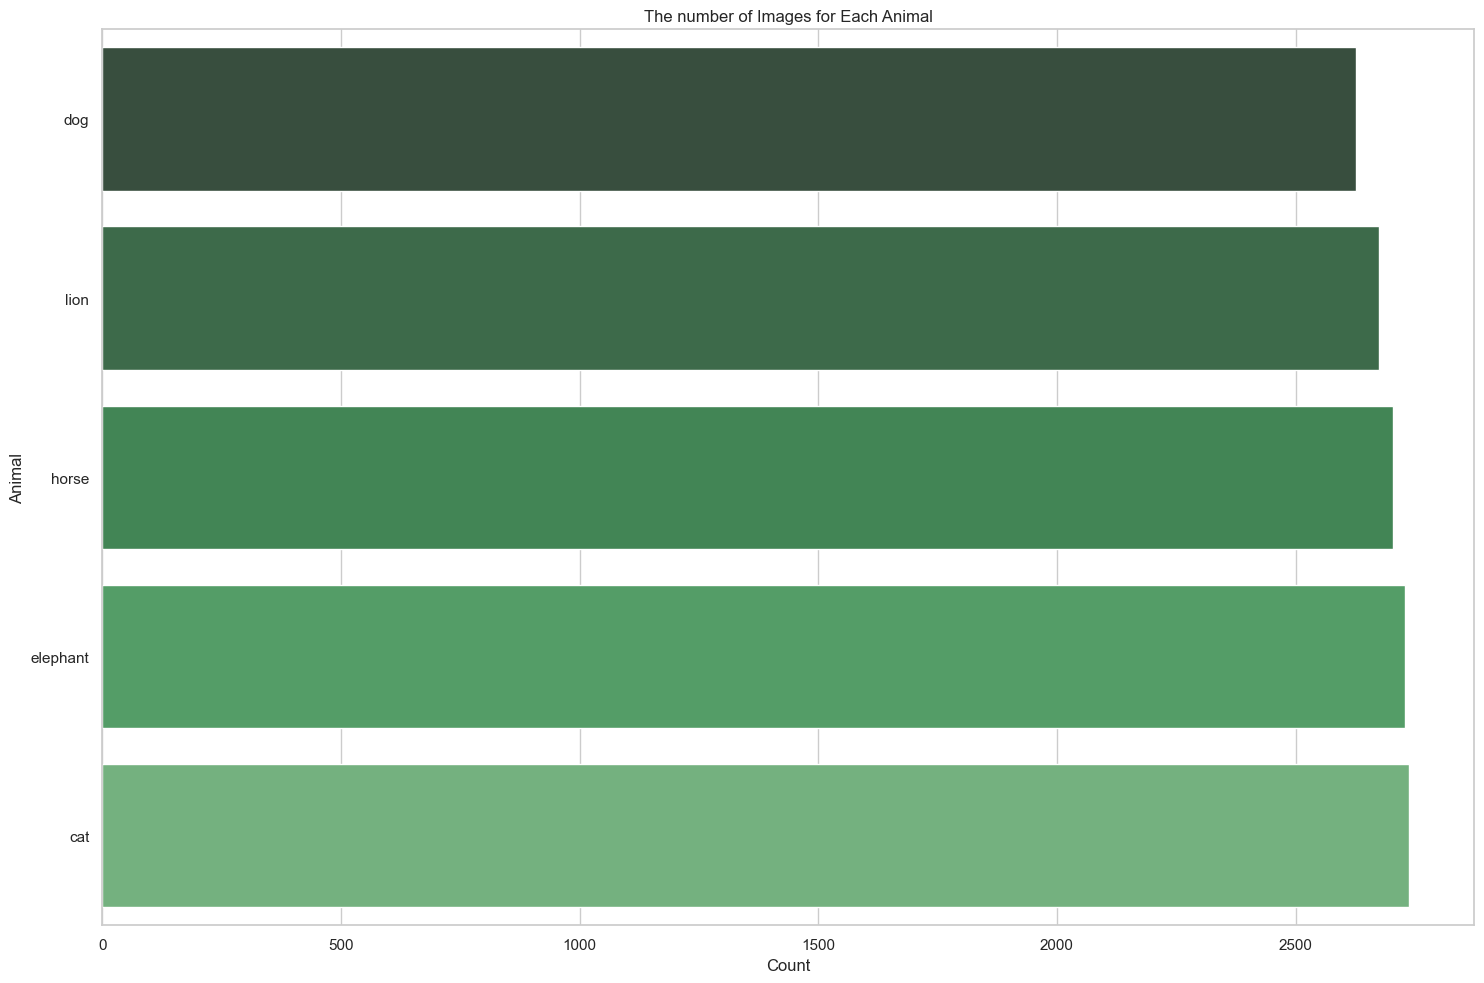

In [136]:
sns.set(style="whitegrid", color_codes=True)
pal = sns.color_palette("Greens_d")
cont_animals = cls_df.groupby('Animal')['Count'].sum().sort_values()
plt.figure(figsize=(15,10))
sns.barplot(x=cont_animals, y=cont_animals.index,palette=np.array(pal[::-1]))
plt.title('The number of Images for Each Animal')
plt.tight_layout()
plt.show()

In [168]:
def view_random(target,class_names,n_samples):
    target_folder = target+'/'+class_names
    ix = random.sample(os.listdir(target_folder),n_samples)

    fig,ax=plt.subplots(ncols=n_samples,figsize=(5,5))
    
    for i in range(n_samples):
        img = mpimg.imread(target_folder + '/' + ix[i])
        ax[i].imshow(img)
        ax[i].set_title(class_names)
        ax[i].axis('off')

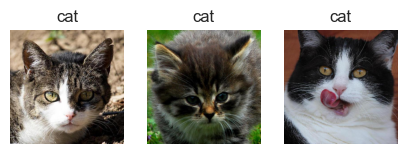

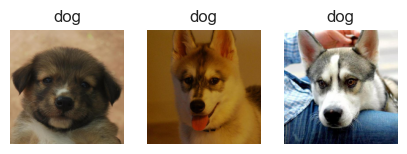

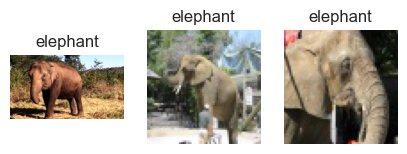

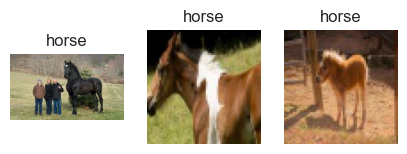

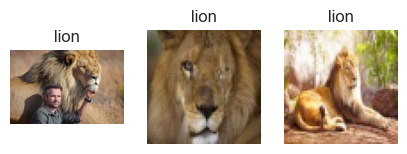

In [169]:
for i in class_names:
    view_random(train_path,i,3)

In [81]:
# get weights of a pre-trained model
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B1_Weights.IMAGENET1K_V2

In [12]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [34]:
train_transform = transforms.Compose([
    #transforms.CenterCrop(224),
    transforms.Resize((256,256)),
    transforms.RandomRotation(degrees=(0, 180)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])    
])

val_transform = transforms.Compose([
    #transforms.CenterCrop(224),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [14]:
class Dataset(Dataset):
    def __init__(self,root_dir,transforms = None):
        self.data = ImageFolder(root_dir,transform=transforms)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]

In [15]:
train_path = '../../Kaggle_Dataset/MultiClass_Classification/Animals/train/'
test_path = '../../Kaggle_Dataset/MultiClass_Classification/Animals/test/'



train_dataset = Dataset(train_path,train_transform)
test_dataset = Dataset(test_path,val_transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], 
                                           generator=torch.Generator().manual_seed(42))

In [16]:
len(train_dataset),len(val_dataset), len(test_dataset)

(10779, 2695, 1497)

In [17]:
class_names = ImageFolder(train_path).classes
class_names

['cat', 'dog', 'elephant', 'horse', 'lion']

In [18]:
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_dataloader = DataLoader(test_dataset,shuffle=True)

In [19]:
image , label = next(iter(train_dataloader))
image.shape , label.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16]))

# 2.Model

In [24]:
model = torchvision.models.efficientnet_b1(weights=weights).to(device)

In [14]:
summary(model, input_size=[32, 3, 256, 256],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 256, 256]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 32, 128, 128]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 256, 256]    [32, 32, 128, 128]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Sequential (1)                                        [32, 32, 128, 128]   [32, 16, 128

In [15]:
# freeze layers
for param in model.features.parameters():
    param.requires_grad = False

In [16]:
# fine-tune the model
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=NUM_CLASSES, # same number of output units as our number of classes
                    bias=True)).to(device)

In [17]:
'''
model.fc = torch.nn.Linear(in_features=512, 
                    out_features=NUM_CLASSES, # same number of output units as our number of classes
                    bias=True).to(device)
'''

'\nmodel.fc = torch.nn.Linear(in_features=512, \n                    out_features=NUM_CLASSES, # same number of output units as our number of classes\n                    bias=True).to(device)\n'

In [18]:
summary(model, input_size=[32, 3, 256, 256],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 256, 256]    [32, 5]              --                   Partial
├─Sequential (features)                                      [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 32, 128, 128]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 256, 256]    [32, 32, 128, 128]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 128, 128]   [32, 32, 128, 128]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Sequential (1)                                        [32, 32, 128, 128]   [32, 

# 3.Loss & optimizer

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

# 4.Train & Val

In [20]:
from train_test import train

In [21]:
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  | train_loss: 0.5557 | val_loss: 0.3334 | train_acc: 81.67% | val_acc: 89.78%  
Epoch: 2  | train_loss: 0.3909 | val_loss: 0.2838 | train_acc: 85.89% | val_acc: 89.68%  
Epoch: 3  | train_loss: 0.3605 | val_loss: 0.2799 | train_acc: 86.53% | val_acc: 90.24%  
Epoch: 4  | train_loss: 0.3607 | val_loss: 0.2626 | train_acc: 86.23% | val_acc: 90.34%  
Epoch: 5  | train_loss: 0.3452 | val_loss: 0.2600 | train_acc: 87.10% | val_acc: 90.52%  
Epoch: 6  | train_loss: 0.3437 | val_loss: 0.2489 | train_acc: 87.14% | val_acc: 90.74%  
Epoch: 7  | train_loss: 0.3370 | val_loss: 0.2320 | train_acc: 87.02% | val_acc: 91.08%  
Epoch: 8  | train_loss: 0.3338 | val_loss: 0.2444 | train_acc: 87.51% | val_acc: 90.85%  
Epoch: 9  | train_loss: 0.3256 | val_loss: 0.2416 | train_acc: 87.73% | val_acc: 90.34%  
Epoch: 10  | train_loss: 0.3179 | val_loss: 0.2431 | train_acc: 87.79% | val_acc: 90.60%  


# 5.Plot Loss Curve

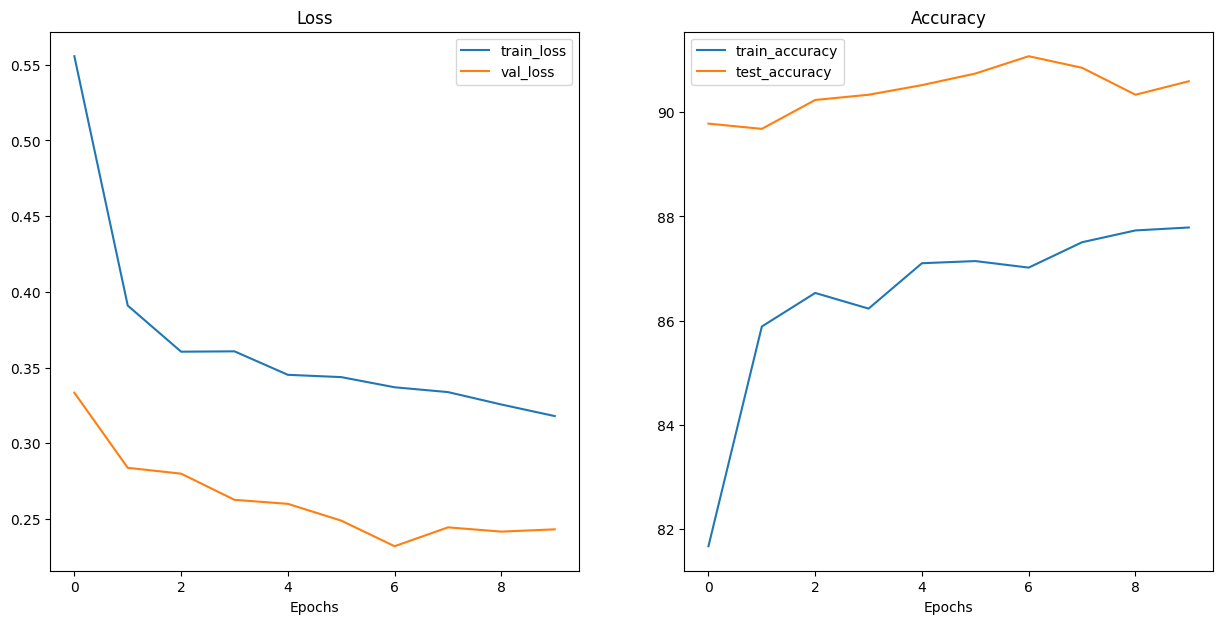

In [22]:
from loss_acc_curves import plot_loss_curves
plot_loss_curves(model_0_results)

# 6.Saving & Loading

In [23]:
MODEL_PATH = 'models'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
# Create model save path 
MODEL_NAME = "model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH + '/' + MODEL_NAME

# Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH) 

Saving model to: models/model_3.pth


In [6]:
loaded_model = torchvision.models.efficientnet_b1().to(device)

loaded_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=NUM_CLASSES,
                    bias=True)).to(device)

loaded_model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

# 7.Evaluate On Test Data

In [7]:
def accuracy_fn(y_pred,y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100             
    return acc

In [8]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device=device):
    test_loss,test_acc=0,0
    model.to(device)
    model.eval()
    pred = []
    true = []
    with torch.inference_mode():
        for X,y in data_loader:
            X, y = X.to(device), y.to(device)
            true.append(y.item())
            y_logits = model(X)
            y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            pred.append(y_pred.item())
            loss = loss_fn(y_logits,y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y,y_pred.clone())
    test_loss /= len(data_loader)
    test_acc  /= len(data_loader)
    return test_loss, test_acc, pred, true

In [26]:
test_loss, test_acc, pred, true = test_step(loaded_model, test_dataloader, loss_fn, device)

In [27]:
print(f'test loss = {test_loss:.4f}')
print(f'test accuracy = {test_acc:.2f}%')

test loss = 0.1156
test accuracy = 95.79%


,precision,recall,f1-score,support
0.0,1.000000,1.000000,1.000000,300.000000
1.0,0.967638,0.996667,0.981938,300.000000
2.0,0.932660,0.926421,0.929530,299.000000
3.0,0.971930,0.923333,0.947009,300.000000
4.0,0.918301,0.942953,0.930464,298.000000
accuracy,0.957916,0.957916,0.957916,0.957916
macro avg,0.958106,0.957875,0.957788,1497.000000
weighted avg,0.958176,0.957916,0.957843,1497.000000


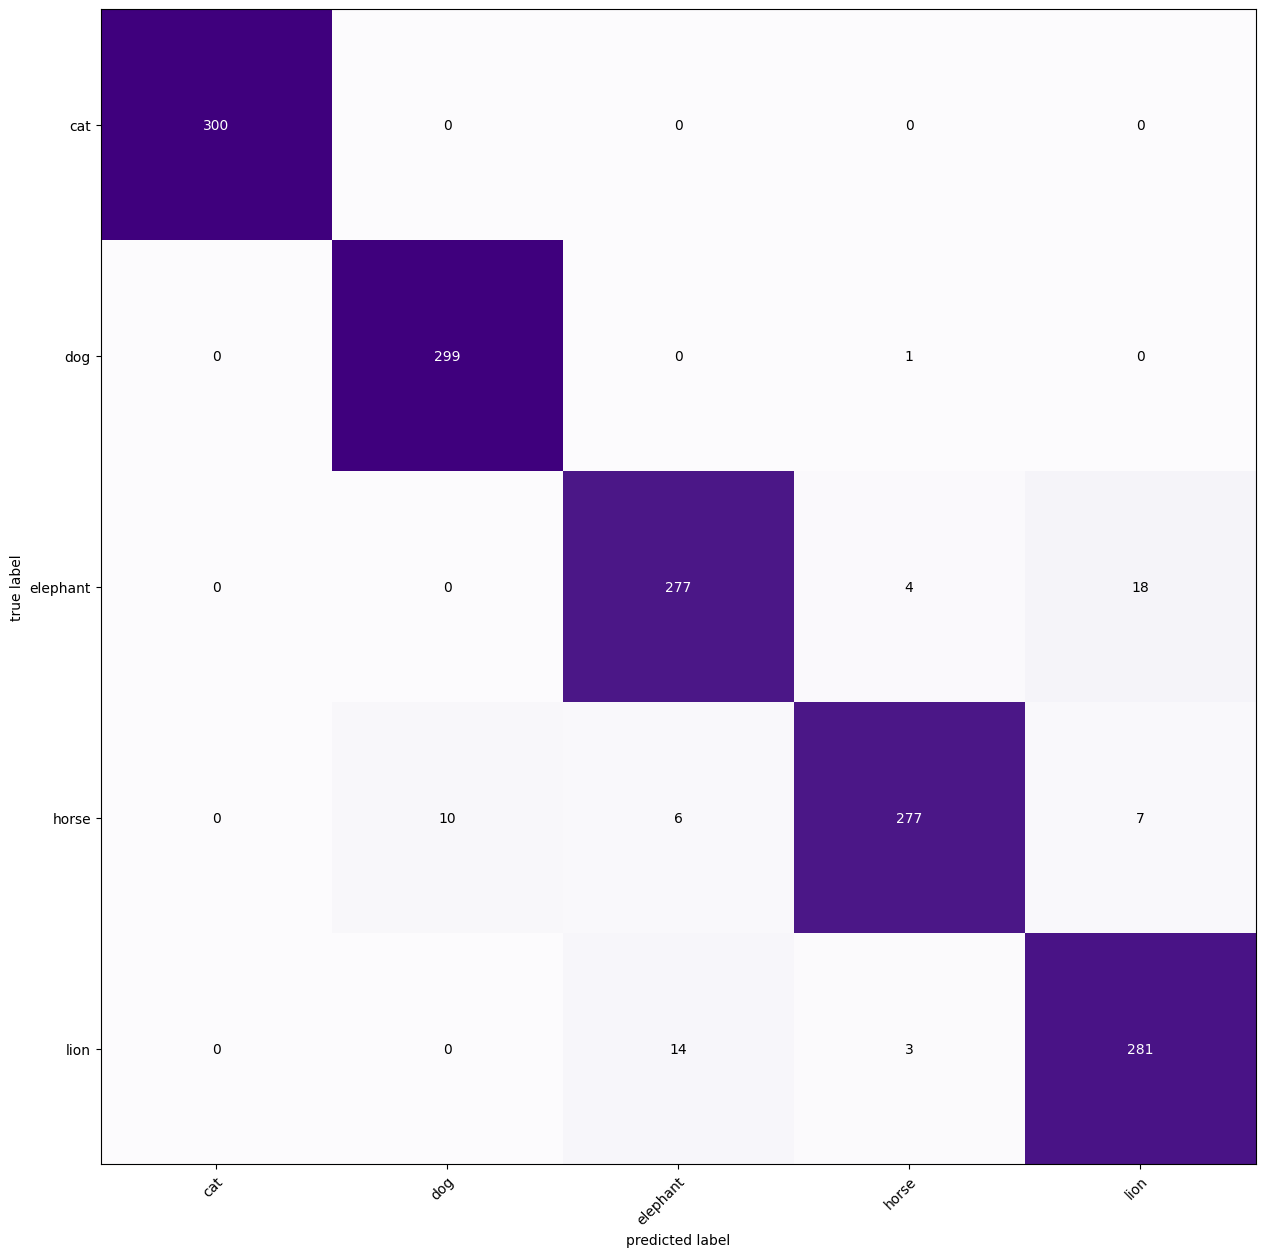

In [81]:
from confusion_matrix import confusionMatrix as cm
actual = torch.FloatTensor(true)
predictions = torch.FloatTensor(pred)
cm(actual,predictions,class_names,task='multiclass',cmap='Purples')

# 8.Inference

In [28]:
def test(model,image_path: str, 
               transform=None,
               device: torch.device = device):
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    if transform:
        target_image = transform(target_image)
        
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)
        y_logits = model(target_image.to(device))
        print(f"logits : {y_logits.cpu().numpy().squeeze()}\n")
        target_image_pred_probs = torch.softmax(y_logits,dim=1)
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
        
    #predictions = torch.FloatTensor(target_image_pred_label)
    return target_image_pred_label,target_image_pred_probs

In [35]:
test_path = '../../Kaggle_Dataset/MultiClass_Classification/Animals/inf/'
y_list = []
pred_list = []
images_path_list = []
for images in os.listdir(test_path):
    # check if the image ends with jpg
    if (images.endswith(".jpg")):
        image_path = os.path.join(test_path,images)
        images_path_list.append(image_path)
        image_index = class_names.index(images.split('.')[0]) #extract name from .jpg then extract index of class
        y_list.append(image_index)
        y_pred,y_prob = test(loaded_model,image_path,test_transform,device)
        pred_list.append(y_pred.item())
        print(f"actual : {image_index} | pred : {y_pred.max()} | prob : {y_prob.max():.3f}\n")
print(f"actual : {y_list}")
print(f"prediction : {pred_list}")

logits : [ 6.9009266 -0.9760988 -1.342401  -2.9951766  1.8081201]

actual : 0 | pred : 0 | prob : 0.993

logits : [-1.7861862   1.6324575   0.66361696  1.4620156   0.43374574]

actual : 1 | pred : 1 | prob : 0.391

logits : [-3.473604  -2.8424323  5.3485937 -0.6679668  0.6446758]

actual : 2 | pred : 2 | prob : 0.988

logits : [-1.5476799  -1.0708216   0.06771226  5.753822   -1.5628331 ]

actual : 3 | pred : 3 | prob : 0.994

logits : [-0.52600604  0.4996074  -1.0300311  -1.2289157   7.6385055 ]

actual : 4 | pred : 4 | prob : 0.999

actual : [0, 1, 2, 3, 4]
prediction : [0, 1, 2, 3, 4]


In [199]:
from pred_and_plot import pred_and_plot_image

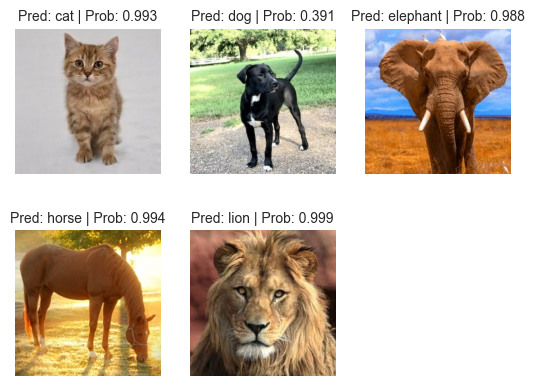

In [198]:
for i in range(5):
    #plt.figure(figsize=(5, 5))
    plt.subplot(2, 3, i+1)
    pred_and_plot_image(model=loaded_model,
                    image_path=images_path_list[i],
                    class_names=class_names,
                    transform=test_transform,
                    device=device)

# 9. Deploy

In [73]:
def predict(inp):
    target_image = transforms.ToTensor()(inp).unsqueeze(dim=0)
        
    loaded_model.to(device)
    loaded_model.eval()
    with torch.inference_mode():
        y_logits = loaded_model(target_image.to(device))
        prediction  = torch.softmax(y_logits,dim=1).cpu().tolist()[0]
        confidences = {class_names[i]: float(prediction[i]) for i in range(5)}
    return confidences

In [80]:
gr.Interface(fn=predict,
             inputs=gr.Image(type="pil"),
             outputs=gr.Label(),
             examples=images_path_list,
             title='Animals Classification').launch()

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.
